# Debugging Feature Initialization

In [1]:
import numpy as np
import torch

import pyro
import pyro.poutine as poutine
from pyro.contrib.tabular import TreeCat, TreeCatTrainer
from pyro.optim import Adam
from treecat_exp.preprocess import load_data, partition_data
from treecat_exp.util import TRAIN

np.set_printoptions(precision=4)
pyro.set_rng_seed(1)
pyro.get_param_store().clear()
pyro.enable_validation(True)

from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}

In [2]:
args = type("Args", (), {})
args.dataset = "boston_housing"
args.max_num_rows = 9999999999
args.capacity = 8
args.init_size = 1024

Load data.

In [3]:
features, data = load_data(args)
num_rows = len(data[0])
num_cells = num_rows * len(features)
print("loaded {} rows x {} features = {} cells".format(
      num_rows, len(features), num_cells))
print("\n".join(["Features:"] + [str(f) for f in features]))

loaded 506 rows x 14 features = 7084 cells
Features:
Real("CRIM")
Real("ZN")
Real("INDUS")
Boolean("CHAS")
Real("NOX")
Real("RM")
Real("AGE")
Real("DIS")
Real("RAD")
Real("TAX")
Real("PTRATIO")
Real("B")
Real("LSTAT")
Real("MEDV")


Initialize the model.

In [4]:
model = TreeCat(features, args.capacity)
trainer = TreeCatTrainer(model, Adam({}))
for batch in partition_data(data, args.init_size):
    break
trainer.init(batch, init_groups=True)
print("\n".join("{} = {}".format(key, value.data.cpu().numpy())
                for key, value in sorted(pyro.get_param_store().items())))

auto_AGE_loc = [109.8232  37.6914  82.1772  80.3034  72.2826  60.1274  83.7529  30.8597]
auto_AGE_loc_loc = 6.6287007331848145
auto_AGE_loc_scale = 7.389056205749512
auto_AGE_scale = [ 7.0851  5.4147 13.2346 12.6986  4.7777  6.9805  8.7629 15.6442]
auto_AGE_scale_loc = 2.336517810821533
auto_AGE_scale_scale = 1.0
auto_B_loc = [284.4678 418.2053 393.2675 395.0889 259.7473 503.4351 317.7236 371.5428]
auto_B_loc_loc = 10.630395889282227
auto_B_loc_scale = 7.389056205749512
auto_B_scale = [30.9825 49.9404 37.0932 37.881  48.1569 41.2715 33.679  40.1528]
auto_B_scale_loc = 3.5131053924560547
auto_B_scale_scale = 1.0
auto_CHAS_loc = -2.4728081226348877
auto_CHAS_logits = [-2.9811 -2.4734 -2.1739 -2.4416 -2.277  -3.1051 -2.3427 -2.1193]
auto_CHAS_scale = 1.0
auto_CRIM_loc = [-5.4756 -5.8877 -1.235  -1.4207  4.4885 -6.2034 10.2194 12.1215]
auto_CRIM_loc_loc = 1.1430848836898804
auto_CRIM_loc_scale = 7.389056205749512
auto_CRIM_scale = [2.829  2.9412 2.6247 1.9262 3.3606 1.9158 3.6837 2.7713]
a

data mean = 68.6, std = 28.1
auto_AGE_loc = [109.8232  37.6914  82.1772  80.3034  72.2826  60.1274  83.7529  30.8597]
auto_AGE_loc_loc = 6.6287007331848145
auto_AGE_loc_scale = 7.389056205749512
auto_AGE_scale = [ 7.0851  5.4147 13.2346 12.6986  4.7777  6.9805  8.7629 15.6442]
auto_AGE_scale_loc = 2.336517810821533
auto_AGE_scale_scale = 1.0


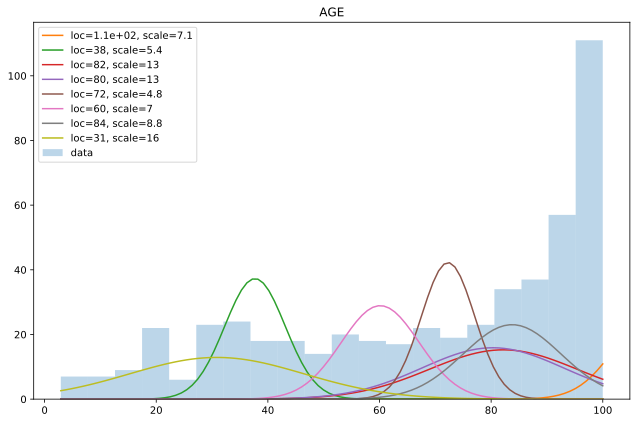

In [5]:
@torch.no_grad()
def plot_feature(name):
    (f, col), = [(f, col) for f, col in zip(features, batch) if f.name == name]
    guide_trace = poutine.trace(model.guide).get_trace(batch)
    with poutine.replay(trace=guide_trace):
        shared = f.sample_shared()
        with pyro.plate("components", args.capacity):
            group = f.sample_group(shared)

    print("data mean = {:0.3g}, std = {:0.3g}".format(col.mean(), col.std()))
    print("\n".join("{} = {}".format(key, value.data.cpu().numpy())
                    for key, value in sorted(pyro.get_param_store().items())
                    if key.startswith("auto_{}_".format(name))))

    pyplot.figure(figsize=(9, 6))
    pyplot.hist(col.numpy(), alpha=0.3, label='data', bins=20)
    x0 = col.min().item()
    x1 = col.max().item()
    X = torch.linspace(x0, x1, 100)
    for i in range(args.capacity):
        d = f.value_dist(group, i)
        Y = d.log_prob(X).exp().numpy() * len(col)
        pyplot.plot(X.numpy(), Y, label='loc={:0.2g}, scale={:0.2g}'.format(d.loc, d.scale))
    pyplot.title(name)
    pyplot.legend(loc='best')
    pyplot.tight_layout()

plot_feature("AGE")